In [1]:
cd ..

/home/janek/mag/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import random
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data, reduce_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_tr_p2, data_vl_p2, idx_te, X_te, y_te = prepare_data(data_tr, data_vl, data_te, seed, 6)

In [6]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.21727741729603234
0.20701168614357263

0.21858694494728995
0.19522240527182866
0.20294599018003273


In [7]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(data_vl_p2[2]))
print(len(y_te))

75208
4792

37564
1214
1222


In [8]:
data_tr_p2 = reduce_dataset(data_tr_p2, len(test_onto), 1325, [idx_te, X_te, y_te])
data_tr = reduce_dataset(data_tr, len(train_onto), 1350, data_vl)
idx_te.extend(data_vl_p2[0])
X_te.extend(data_vl_p2[1])
y_te.extend(data_vl_p2[2])

In [9]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.20594444444444446
0.20701168614357263

0.2001509433962264
0.19522240527182866
0.1990968801313629


In [10]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(y_te))

54000
4792

26500
2436


In [11]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

In [11]:
#FIRST PHASE
T.manual_seed(seed)
reasoner_original = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_original = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_original)} parameters')
print(f'created {len(encoders_original)} encoders with {paramcount(encoders_original[0])} parameters each')

T.manual_seed(seed)
reasoner_mod = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_mod = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_mod)} parameters')
print(f'created {len(encoders_mod)} encoders with {paramcount(encoders_mod[0])} parameters each')

train_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    random.seed(seed)
    if reasoner_name == 'original reasoner':
        train(data_tr, data_vl, reasoner, encoders_original, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger)
    else:
        train_mod(data_tr, data_vl, reasoner, encoders_mod, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger, identities_weight=0.028, identitity_weight_decay=0.96)


created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
original reasoner
train epoch 00/15 | batch 1689/1688 | loss 0.7214 | val loss 0.7207 | acc 0.2068 | f1 0.3427 | prec 0.2068 | recall 0.9990 | roc auc 0.5332 | pr auc 0.2351 | elapsed 16.69s
train epoch 01/15 | batch 1689/1688 | loss 0.5768 | val loss 0.4749 | acc 0.8024 | f1 0.1074 | prec 0.8261 | recall 0.0575 | roc auc 0.6702 | pr auc 0.3595 | elapsed 66.02s
train epoch 02/15 | batch 1689/1688 | loss 0.4498 | val loss 0.4338 | acc 0.8128 | f1 0.2807 | prec 0.6863 | recall 0.1764 | roc auc 0.7706 | pr auc 0.5028 | elapsed 62.35s
train epoch 03/15 | batch 1689/1688 | loss 0.3523 | val loss 0.4031 | acc 0.8397 | f1 0.4733 | prec 0.7403 | recall 0.3478 | roc auc 0.8158 | pr auc 0.6315 | elapsed 60.58s
train epoch 04/15 | batch 1689/1688 | loss 0.2757 | val loss 0.3793 | acc 0.8637 | f1 0.5937 | prec 0.7756 | recall 0.4808

In [13]:
## --- SECOND PHASE
trained_test_encoders = {}
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'original reasoner':
        train(data_tr_p2, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    else:
        train_mod(data_tr_p2, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)


original reasoner
train epoch 00/10 | batch 830/829 | loss 1.4051 | val loss 1.4033 | acc 0.5921 | f1 0.3818 | prec 0.2740 | recall 0.6293 | roc auc 0.6674 | pr auc 0.4728 | elapsed 10.14s
train epoch 01/10 | batch 830/829 | loss 1.2106 | val loss 0.9845 | acc 0.6745 | f1 0.4388 | prec 0.3350 | recall 0.6357 | roc auc 0.7287 | pr auc 0.5371 | elapsed 25.76s
train epoch 02/10 | batch 830/829 | loss 0.8485 | val loss 0.6790 | acc 0.7557 | f1 0.5183 | prec 0.4280 | recall 0.6567 | roc auc 0.7900 | pr auc 0.6142 | elapsed 20.88s
train epoch 03/10 | batch 830/829 | loss 0.5912 | val loss 0.4779 | acc 0.8209 | f1 0.6031 | prec 0.5418 | recall 0.6801 | roc auc 0.8434 | pr auc 0.6973 | elapsed 20.60s
train epoch 04/10 | batch 830/829 | loss 0.4284 | val loss 0.3515 | acc 0.8680 | f1 0.6814 | prec 0.6593 | recall 0.7049 | roc auc 0.8846 | pr auc 0.7737 | elapsed 20.67s
train epoch 05/10 | batch 830/829 | loss 0.3230 | val loss 0.2727 | acc 0.9029 | f1 0.7510 | prec 0.7712 | recall 0.7319 | roc 

In [14]:
with T.no_grad():
    _, _, Y_te_orig = eval_batch(reasoner_original, trained_test_encoders['original reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_mod = eval_batch(reasoner_mod, trained_test_encoders['modified reasoner'], X_te, y_te, idx_te)

local/out/exp/20240808T184236


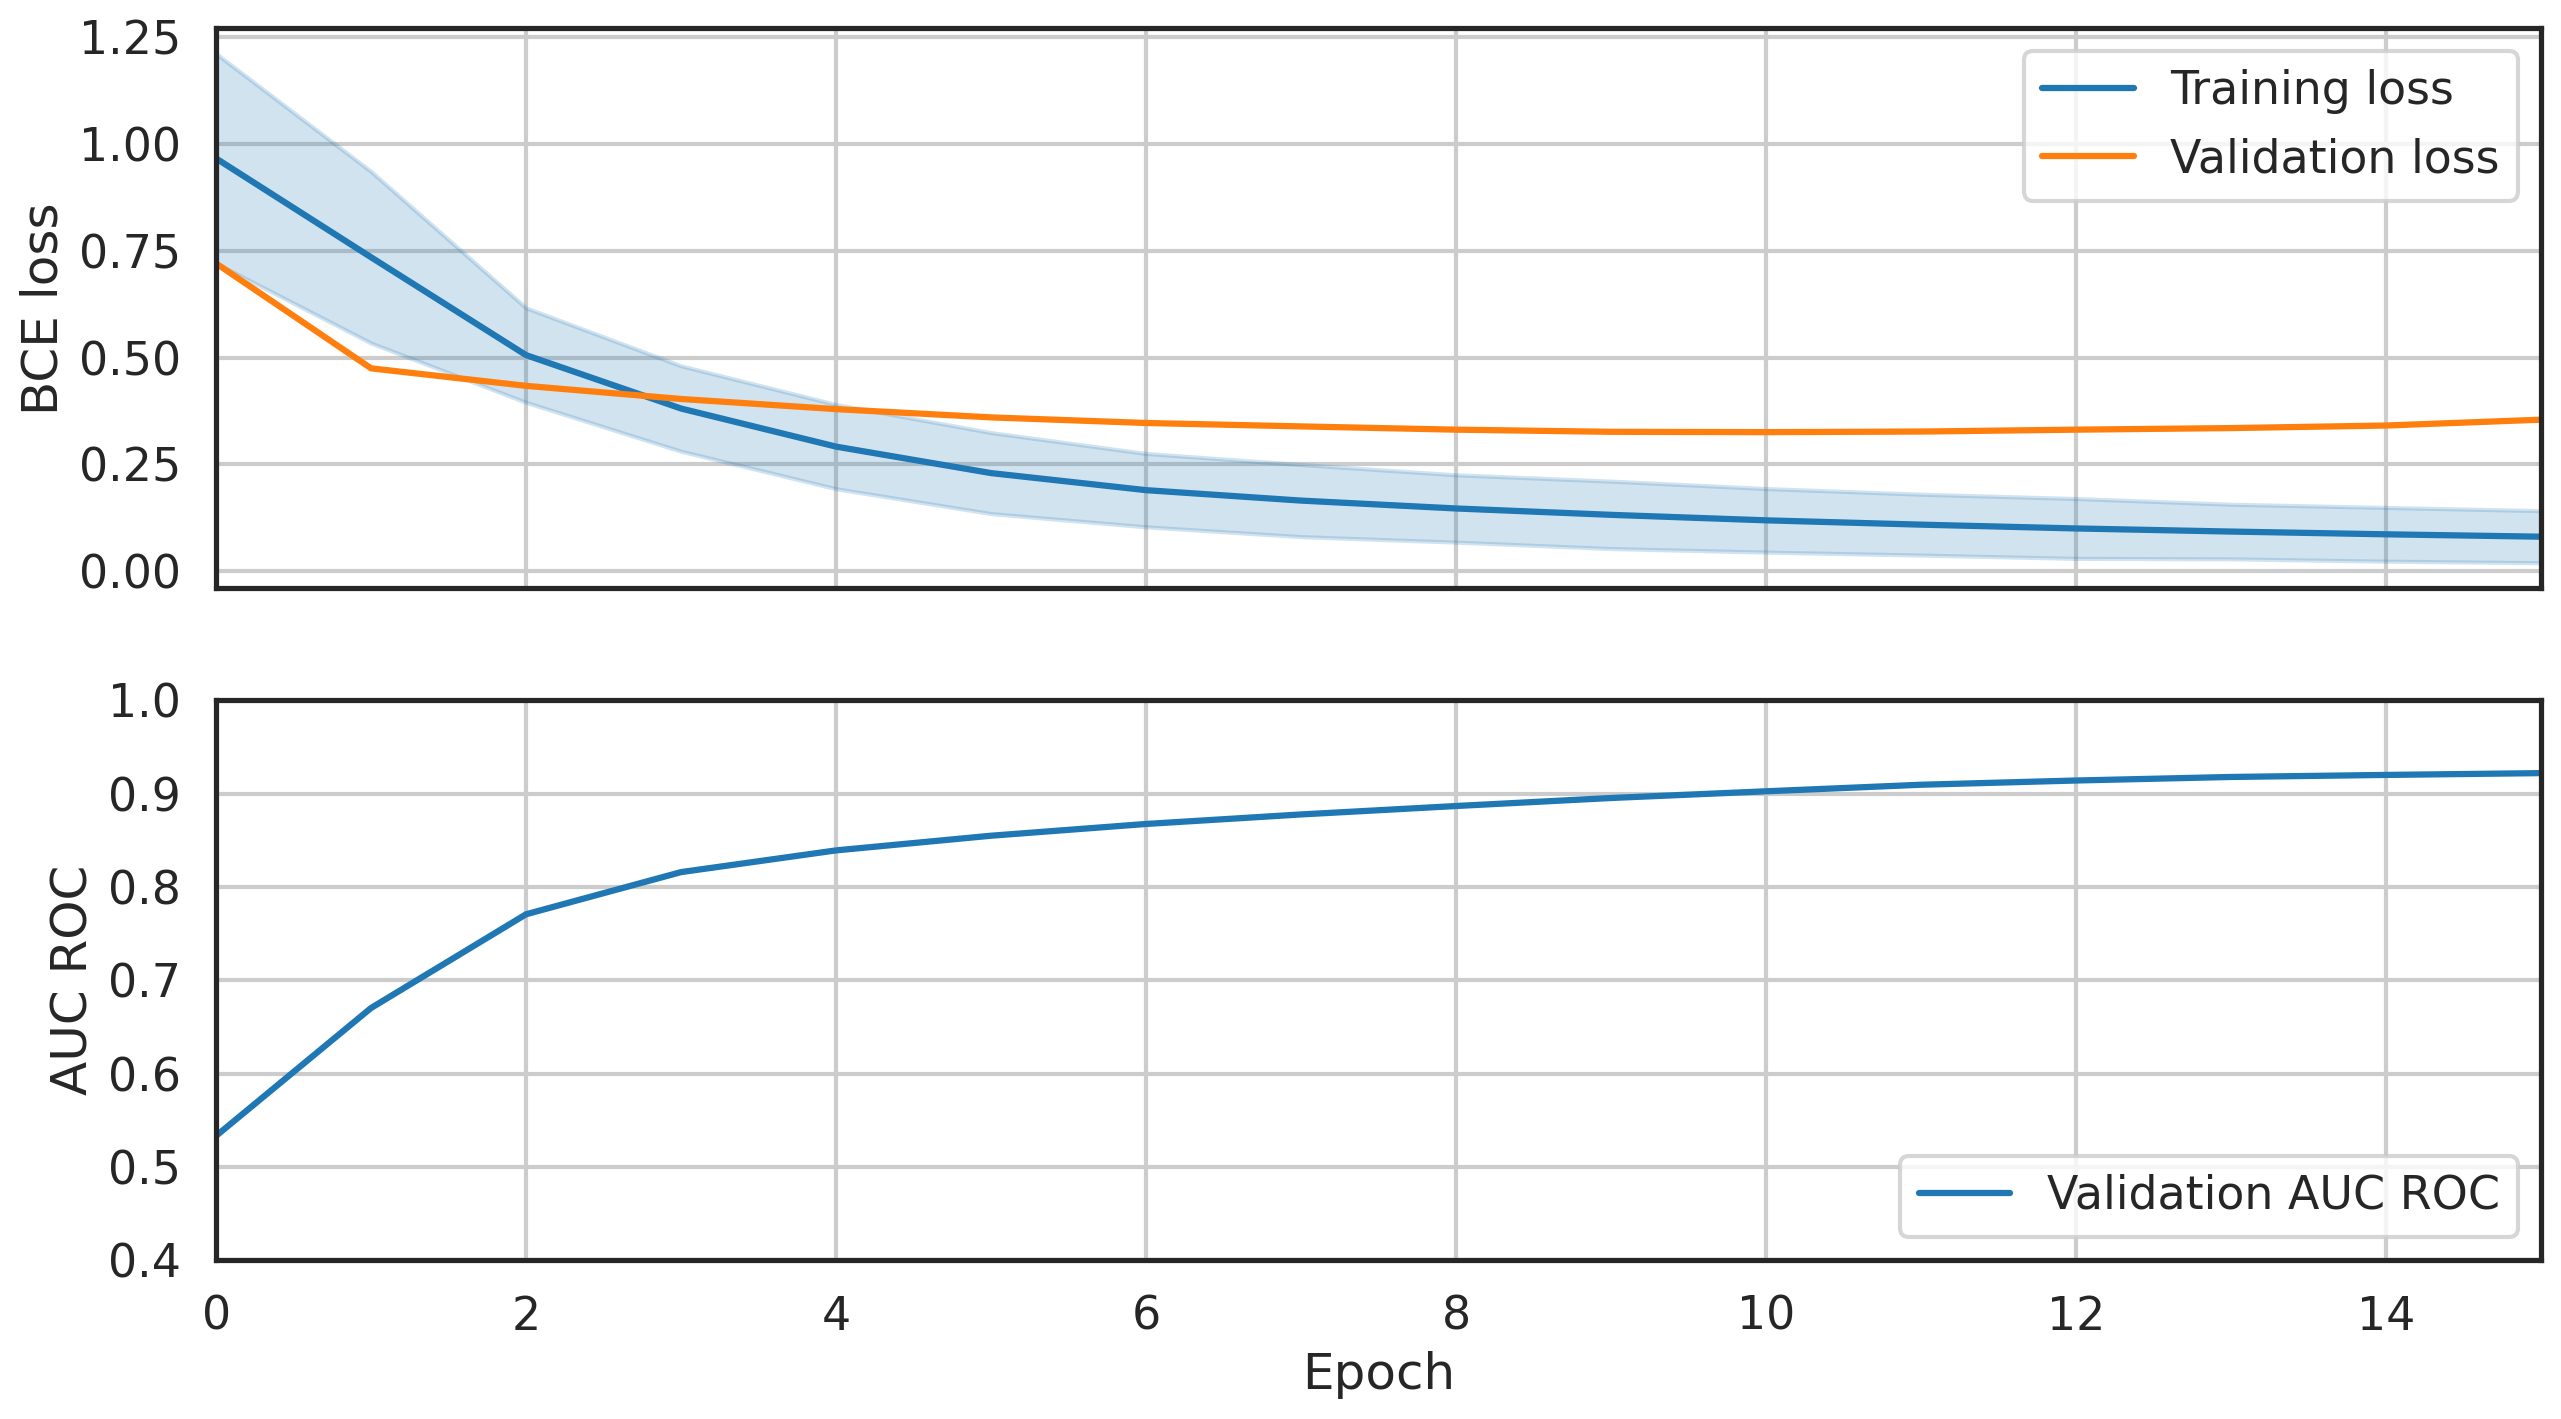

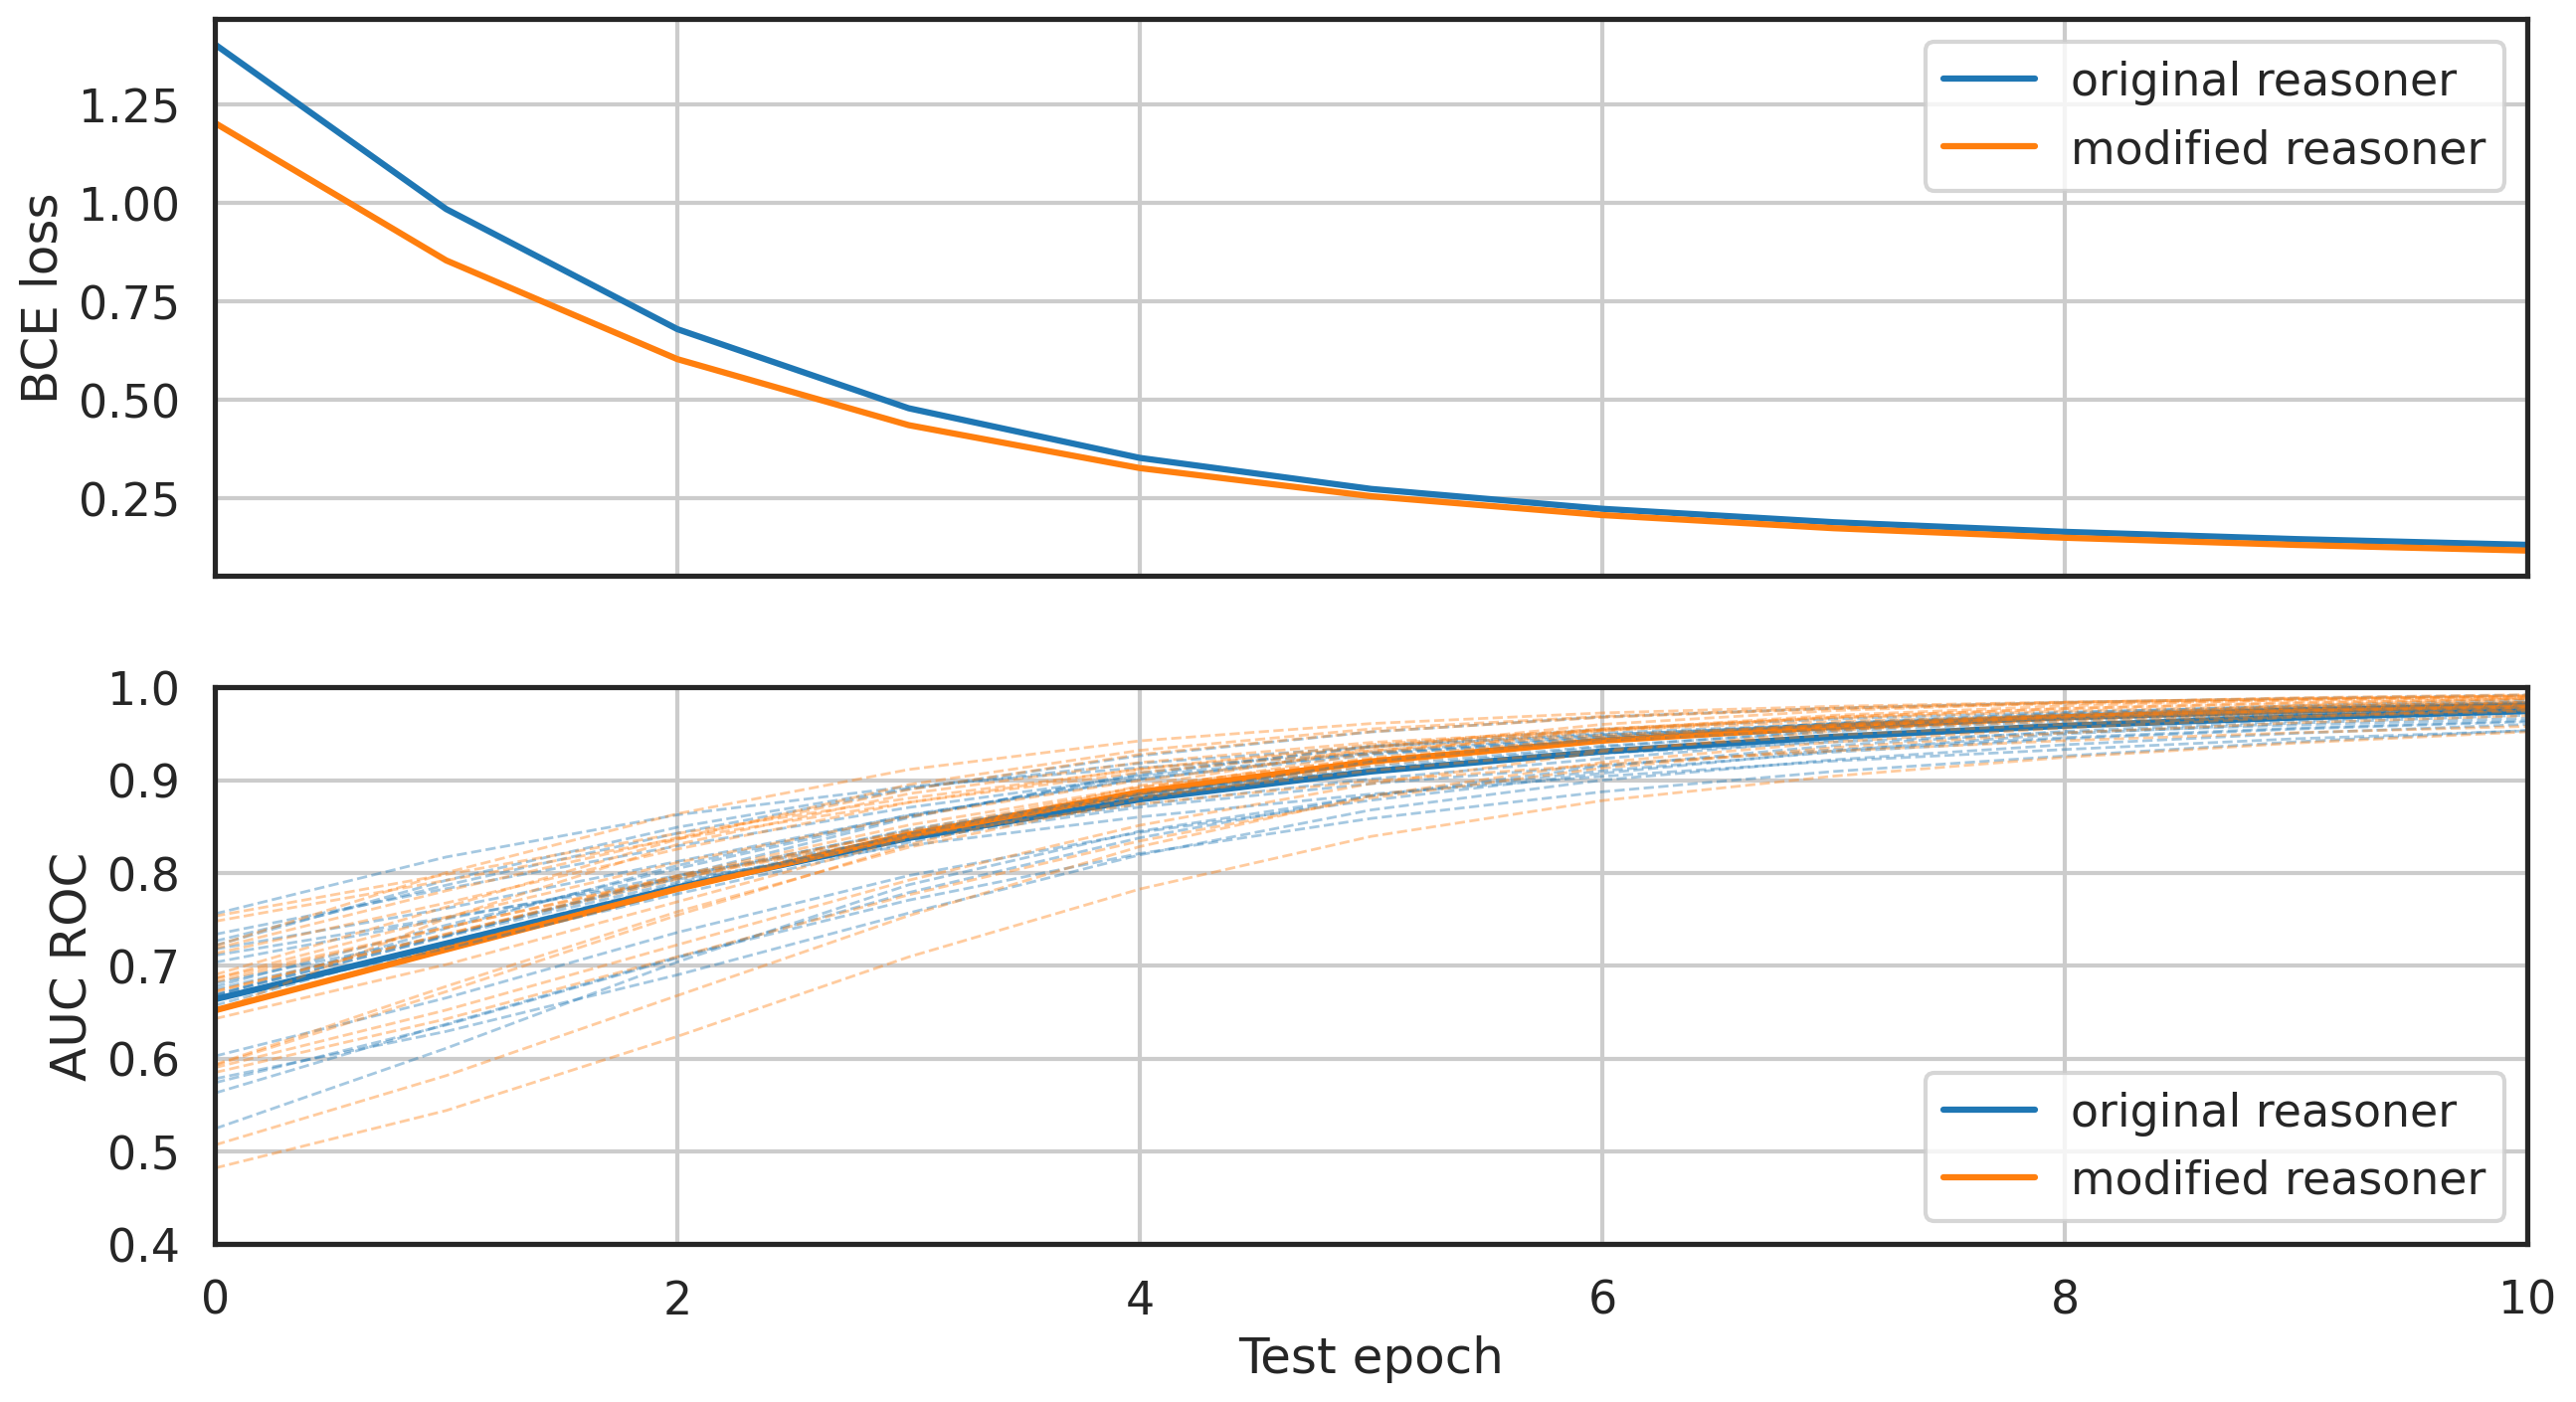

original
             mean       std     micro
acc      0.867353  0.046991  0.867406
prec     0.670266  0.143875  0.678414
recall   0.621563  0.161250  0.635052
f1       0.636923  0.133290  0.656017
auc_roc  0.861765  0.070832  0.866694
auc_pr   0.732825  0.132640  0.743643
modified
             mean       std     micro
acc      0.861335  0.037227  0.861658
prec     0.619186  0.121426  0.637037
recall   0.687690  0.132497  0.709278
f1       0.646958  0.115647  0.671220
auc_roc  0.884022  0.052537  0.888176
auc_pr   0.749133  0.123245  0.770104


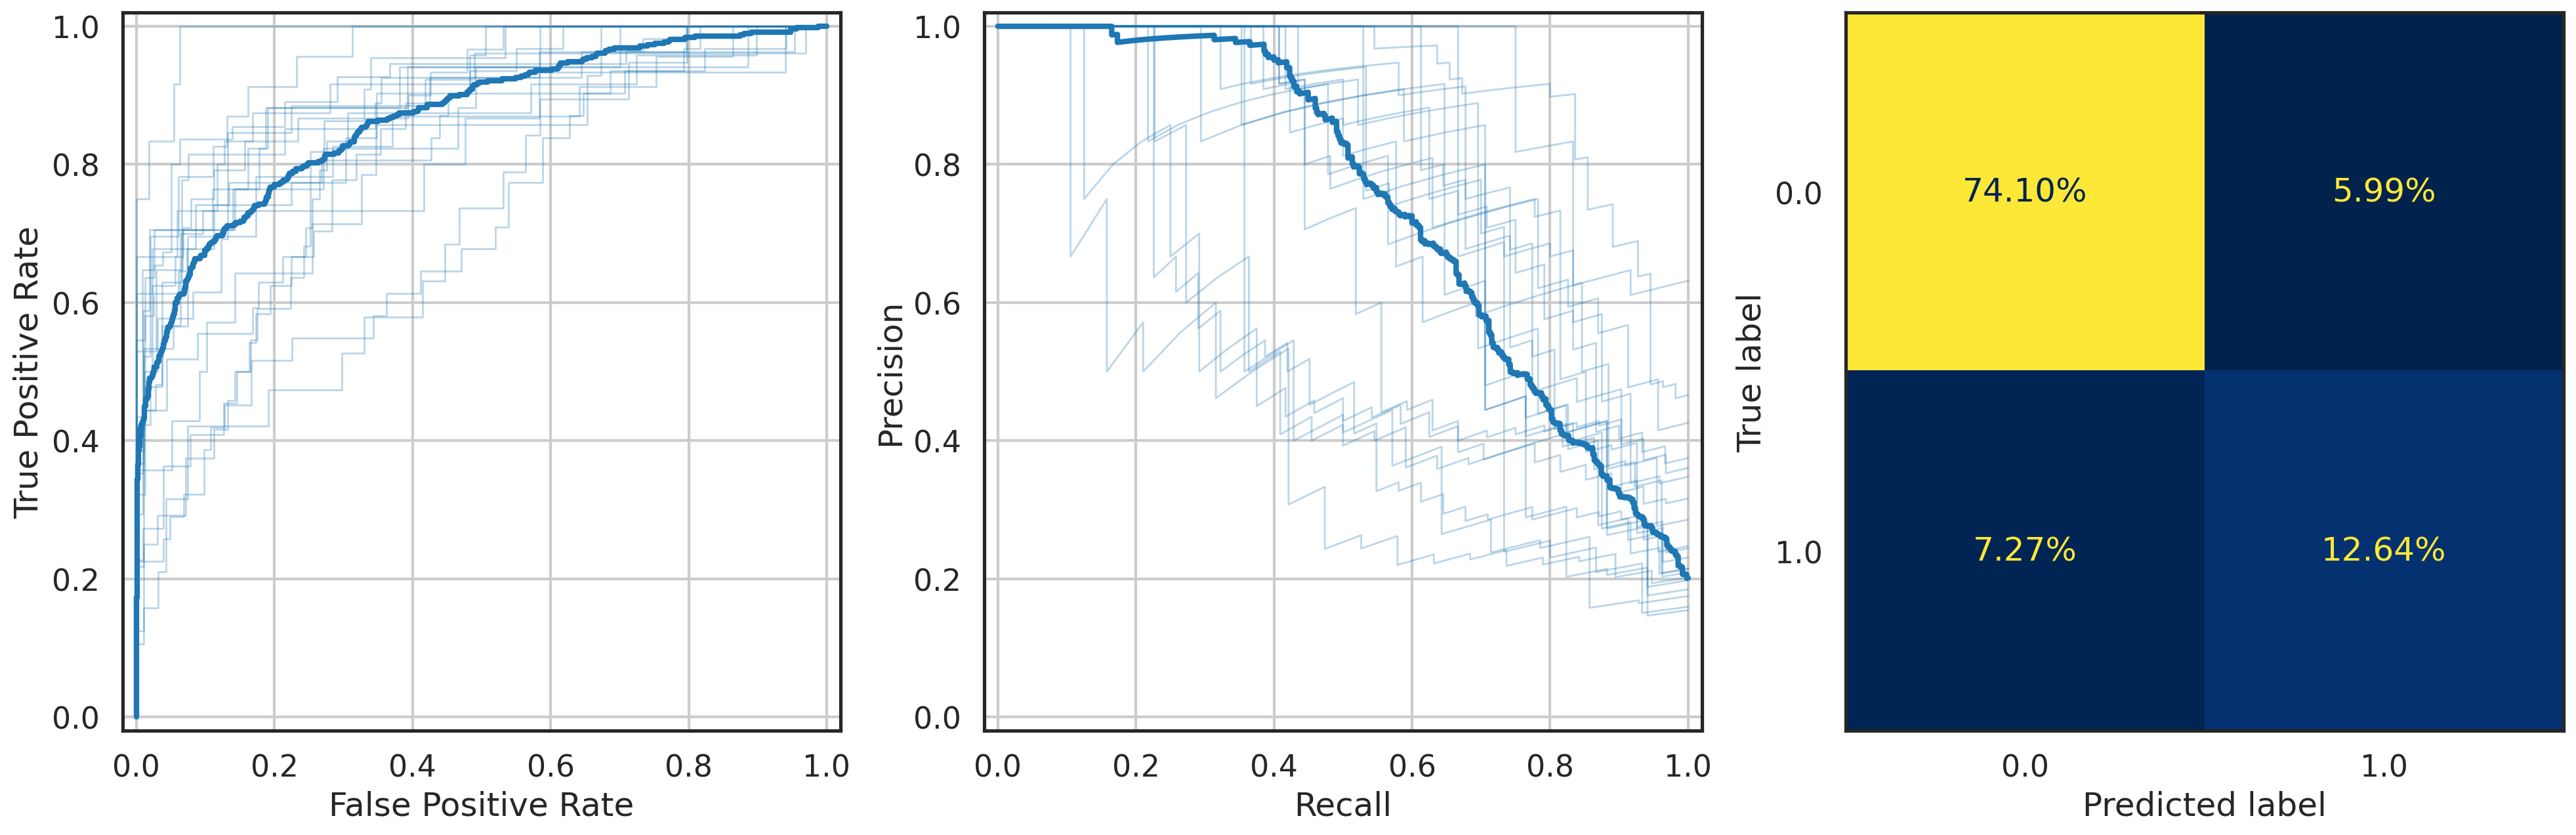

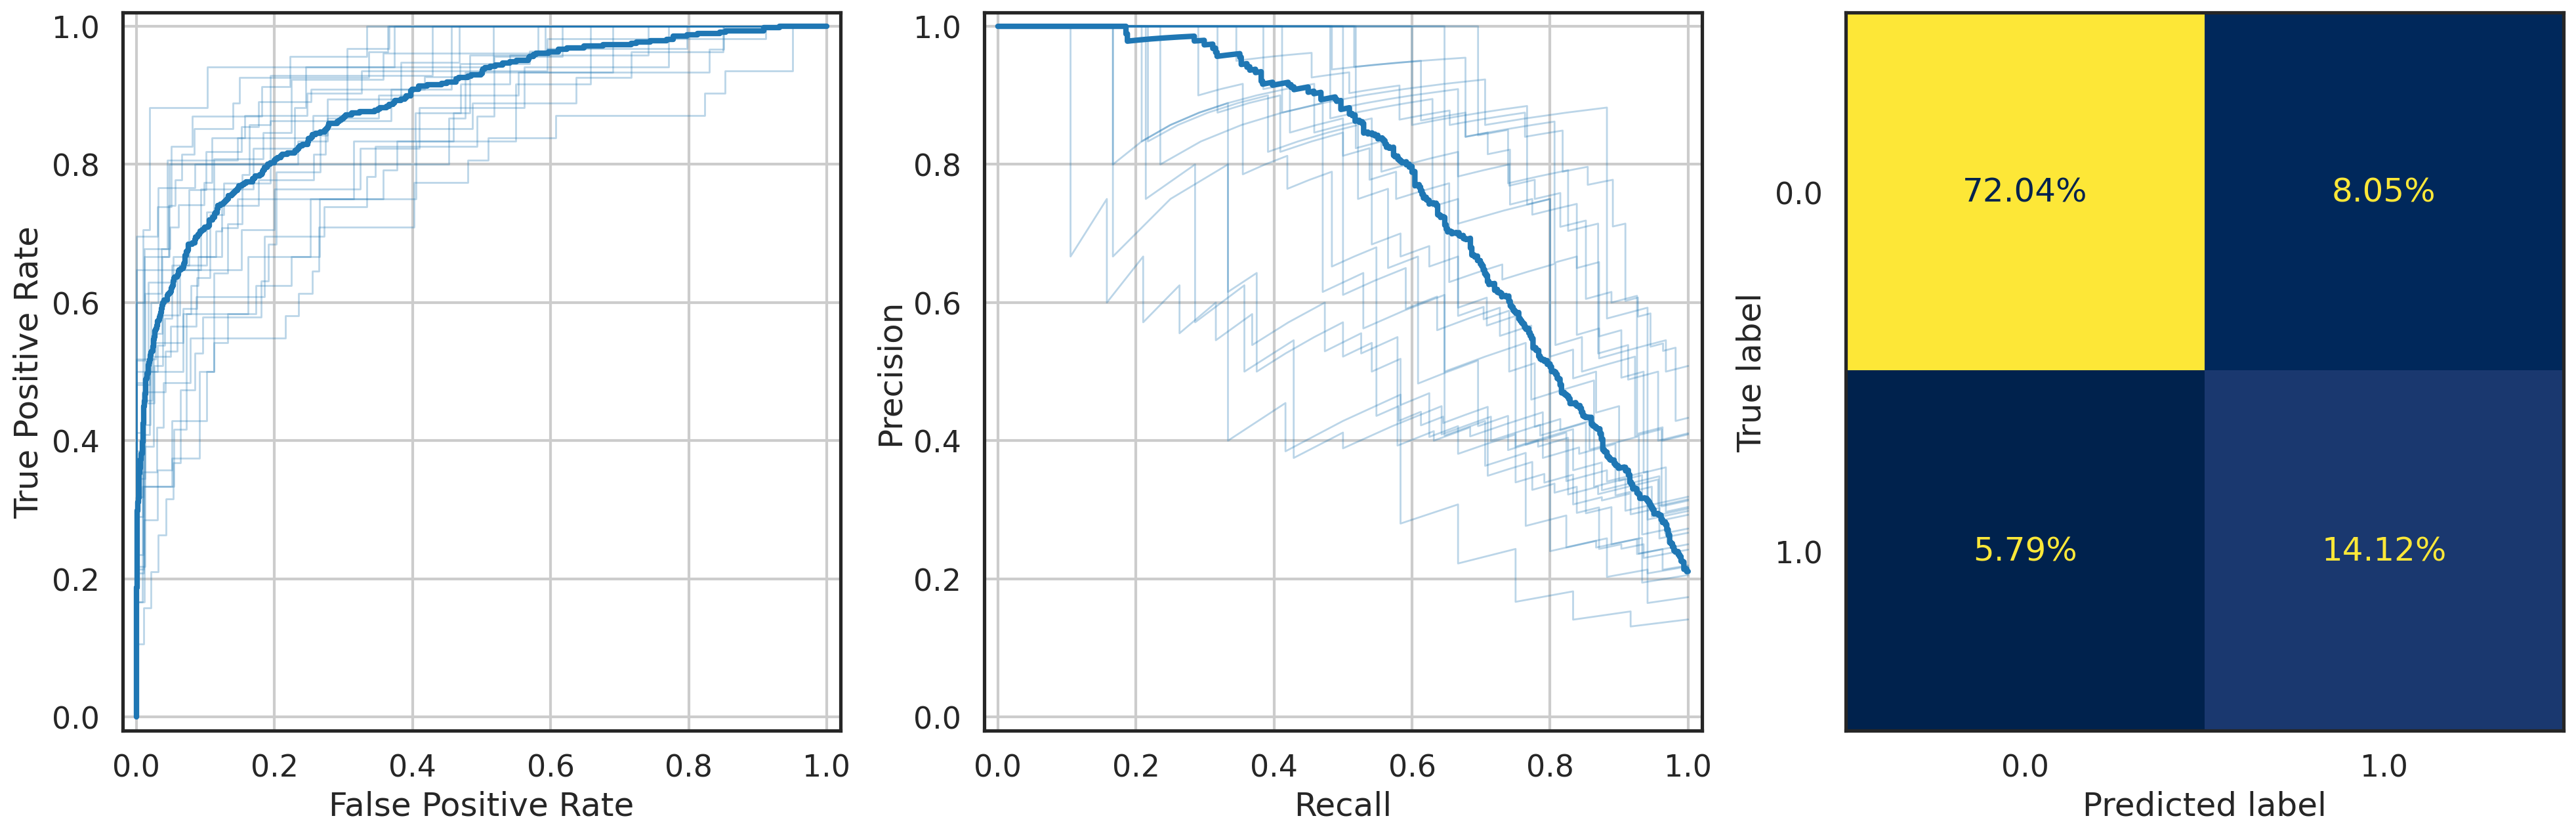

In [16]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(reasoner_original.state_dict(), base+'/reasonerO.pt')
T.save(reasoner_mod.state_dict(), base+'/reasonerM.pt')

df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_orig=Y_te_orig, Y_te_mod=Y_te_mod))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print('original')
print(report(test_onto, y_te, np.array(Y_te_orig), idx_te, save=base+'/%-trained'))
print('modified')
print(report(test_onto, y_te, np.array(Y_te_mod), idx_te, save=base+'/%-random'))

In [17]:
from src.id import print_identity_results
print(print_identity_results(reasoner_original,trained_test_encoders['original reasoner'], seed))

Double Negation:
  Mean Loss: 0.285637
  Std Dev Loss: 0.031352
  Mean Diff: 0.581474
  Std Dev Diff: 0.095603

Duality of Top and Bottom:
  Mean Loss: 0.379092
  Std Dev Loss: 0.000000
  Mean Diff: 0.696303
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.126582
  Std Dev Loss: 0.032194
  Mean Diff: 0.312720
  Std Dev Diff: 0.086605

Associativity:
  Mean Loss: 0.033959
  Std Dev Loss: 0.011461
  Mean Diff: 0.077475
  Std Dev Diff: 0.025209

Commutativity:
  Mean Loss: 0.037499
  Std Dev Loss: 0.012699
  Mean Diff: 0.087809
  Std Dev Diff: 0.032297

Contradiction:
  Mean Loss: 0.376582
  Std Dev Loss: 0.017533
  Mean Diff: 0.827179
  Std Dev Diff: 0.072190

Identity with Top:
  Mean Loss: 0.153383
  Std Dev Loss: 0.036161
  Mean Diff: 0.365695
  Std Dev Diff: 0.108094

Absorption by Bottom:
  Mean Loss: 0.426966
  Std Dev Loss: 0.018707
  Mean Diff: 0.811027
  Std Dev Diff: 0.037404

Top Concept Subsumption:
  Mean Loss: 0.001783
  Std Dev Loss: 0.002497
  Mean Diff: N/A
  Std De

In [18]:
print(print_identity_results(reasoner_mod,trained_test_encoders['modified reasoner'], seed))

Double Negation:
  Mean Loss: 0.000016
  Std Dev Loss: 0.000005
  Mean Diff: 0.000040
  Std Dev Diff: 0.000016

Duality of Top and Bottom:
  Mean Loss: 0.000492
  Std Dev Loss: 0.000000
  Mean Diff: 0.001510
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.115746
  Std Dev Loss: 0.027878
  Mean Diff: 0.270873
  Std Dev Diff: 0.075844

Associativity:
  Mean Loss: 0.021622
  Std Dev Loss: 0.007602
  Mean Diff: 0.048200
  Std Dev Diff: 0.016483

Commutativity:
  Mean Loss: 0.023989
  Std Dev Loss: 0.008609
  Mean Diff: 0.056832
  Std Dev Diff: 0.021015

Contradiction:
  Mean Loss: 0.148933
  Std Dev Loss: 0.037215
  Mean Diff: 0.241854
  Std Dev Diff: 0.042700

Identity with Top:
  Mean Loss: 0.067388
  Std Dev Loss: 0.018447
  Mean Diff: 0.160709
  Std Dev Diff: 0.050377

Absorption by Bottom:
  Mean Loss: 0.019926
  Std Dev Loss: 0.008655
  Mean Diff: 0.050462
  Std Dev Diff: 0.018712

Top Concept Subsumption:
  Mean Loss: 0.000908
  Std Dev Loss: 0.000848
  Mean Diff: N/A
  Std De